In [14]:
#구글드라이브 mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 클라우드 이미지 압축 해제

In [19]:
!pwd

/content/drive/My Drive/Colab Notebooks/Data-Science/data


In [20]:
%cd rock_scissor_paper/

/content/drive/My Drive/Colab Notebooks/Data-Science/data/rock_scissor_paper


In [ ]:
%cd rock
!unzip rock.zip

In [ ]:
%cd ../scissor/
!unzip scissor.zip

In [ ]:
%cd ../paper/
!unzip paper.zip

## 2. 데이터 불러오기 + Resize 하기

In [30]:
from PIL import Image
import os, glob


In [31]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

  # 파일마다 모두 28x28 사이즈로 바꾸어 저장
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper/scissor'
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")

image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper/rock'
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper/paper'
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

994  images to be resized.
994  images resized.
가위 이미지 resize 완료!
1105  images to be resized.
1105  images resized.
바위 이미지 resize 완료!
1108  images to be resized.
1108  images resized.
보 이미지 resize 완료!


## 3. 이미지 라벨링(가위: 0, 바위: 1, 보: 2)

In [32]:
import numpy as np

def load_data(img_path, number_of_data=3207):  # 가위바위보 이미지 개수 총합에 주의
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper'
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 3207 입니다.
x_train shape: (3207, 28, 28, 3)
y_train shape: (3207,)


0


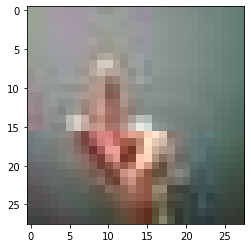

In [33]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
print(y_train[0])

## 4. 딥러닝 네트워크 설계하기

In [39]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

channel_1 = 32
channel_2 = 64
dense = 64
train_epoch = 10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
#model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
#model.add(keras.layers.MaxPooling2D((2,2)))

# overfitting.....
#model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                102464    
_________________________________________________________________
dense_3 (Dense)              (

## 5. Train

### **5-1. train set, test set 나누기**
- hyper parameter 수정  
=> `accuracy` : 92%

In [40]:
from sklearn.model_selection import train_test_split
x_train_split, x_test, y_train_split, y_test = train_test_split(x_train, y_train, test_size=0.2)

x_train_split_norm = x_train/255.0  # normalize to 0~1
x_test_norm = x_test/255.0   

print(x_train_split.shape)
print(x_test.shape)
print(y_train_split.shape)
print(y_test.shape)

(2565, 28, 28, 3)
(642, 28, 28, 3)
(2565,)
(642,)


1


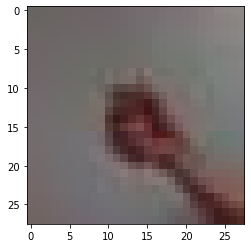

In [41]:
idx = 1
plt.imshow(x_test[idx])
print(y_test[idx])

#### train model

In [42]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.compile()과 model.fit()을 사용해 봅시다.
# [[YOUR CODE]]

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_split, y_train_split, epochs=train_epoch)

Epoch 1/10
81/81 [==============================] - 2s 21ms/step - loss: 9.5692 - accuracy: 0.4172
Epoch 2/10
81/81 [==============================] - 2s 21ms/step - loss: 0.8369 - accuracy: 0.6086
Epoch 3/10
81/81 [==============================] - 2s 21ms/step - loss: 0.6177 - accuracy: 0.7259
Epoch 4/10
81/81 [==============================] - 2s 21ms/step - loss: 0.4520 - accuracy: 0.8234
Epoch 5/10
81/81 [==============================] - 2s 21ms/step - loss: 0.3344 - accuracy: 0.8749
Epoch 6/10
81/81 [==============================] - 2s 21ms/step - loss: 0.2723 - accuracy: 0.9002
Epoch 7/10
81/81 [==============================] - 2s 21ms/step - loss: 0.2281 - accuracy: 0.9224
Epoch 8/10
81/81 [==============================] - 2s 22ms/step - loss: 0.1559 - accuracy: 0.9481
Epoch 9/10
81/81 [==============================] - 2s 21ms/step - loss: 0.1384 - accuracy: 0.9513
Epoch 10/10
81/81 [==============================] - 2s 21ms/step - loss: 0.1194 - accuracy: 0.9595


#### test accuracy 측정

In [43]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

21/21 - 0s - loss: 0.2002 - accuracy: 0.9252
test_loss: 0.200225830078125 
test_accuracy: 0.9252336621284485


#### model이 실제로 추론한 확률분포

model.predict() 결과 :  [0.00650011 0.98850036 0.00499957]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1


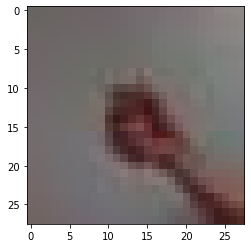

In [46]:
#예측
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=1  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

### **※ 5-2. 새로운 data set으로 test할 경우**   
- hyper parameter를 수정하고, train dataset을 `Dropout`시켜 `overfitting`을 막고자 함  
=> `accuracy` : 61%

#### new test 이미지 데이터

In [ ]:
!pwd
%cd ../test/rock/
!unzip rock.zip
%cd ../scissor/
!unzip scissor.zip
%cd ../paper/
!unzip paper.zip

In [ ]:
# test img resize(28*28)
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper/test/scissor'
resize_images(image_dir_path)

image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper/test/rock'
resize_images(image_dir_path)

image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper/test/paper'
resize_images(image_dir_path)
print("이미지 resize 완료!")

In [ ]:
# 0,1,2 라벨링
image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper/test/'
(x_test_new, y_test_new)=load_data(image_dir_path, 274)
x_test_new_norm = x_test_new/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test_new shape: {}".format(x_test_new.shape))
print("y_test_new: {}".format(y_test_new.shape))

#### 딥러닝 네트워크 설계

In [84]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

channel_1 = 32
channel_2 = 64
dense = 64

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

# overfitting.....
model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  10
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
dropout_8 (Dropout)         

#### 모델 train

In [85]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.compile()과 model.fit()을 사용해 봅시다.
# [[YOUR CODE]]
train_epoch = 15

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=train_epoch)

Epoch 1/15
101/101 [==============================] - 3s 24ms/step - loss: 2.0693 - accuracy: 0.4571
Epoch 2/15
101/101 [==============================] - 2s 24ms/step - loss: 0.7667 - accuracy: 0.6333
Epoch 3/15
101/101 [==============================] - 2s 24ms/step - loss: 0.6578 - accuracy: 0.6991
Epoch 4/15
101/101 [==============================] - 2s 24ms/step - loss: 0.5065 - accuracy: 0.7767
Epoch 5/15
101/101 [==============================] - 2s 24ms/step - loss: 0.4455 - accuracy: 0.8045
Epoch 6/15
101/101 [==============================] - 2s 24ms/step - loss: 0.3333 - accuracy: 0.8637
Epoch 7/15
101/101 [==============================] - 2s 25ms/step - loss: 0.2909 - accuracy: 0.8856
Epoch 8/15
101/101 [==============================] - 2s 24ms/step - loss: 0.2003 - accuracy: 0.9199
Epoch 9/15
101/101 [==============================] - 2s 25ms/step - loss: 0.1929 - accuracy: 0.9236
Epoch 10/15
101/101 [==============================] - 2s 24ms/step - loss: 0.1647 - accura

#### Test

In [86]:
test_loss, test_accuracy = model.evaluate(x_test_new,y_test_new, verbose=2)
print("test_loss_new: {} ".format(test_loss))
print("test_accuracy_new: {}".format(test_accuracy))

9/9 - 0s - loss: 1.5741 - accuracy: 0.6168
test_loss_new: 1.5740697383880615 
test_accuracy_new: 0.6167883276939392
